In [1]:
import lda
import pandas as pd
import numpy as np
import json

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import re

import pyLDAvis.sklearn
import pyLDAvis

from lda import (
  get_text,
  lda_preprocess,
  lda_gridsearch,
  lda_topic_modeling,
  major_topic_per_doc,
  plot_top_words,
  show_topics,
)

In [3]:
# load squad, otquad
# get only the contexts
# each context is a document
# create a dataframe with both of them with a column named data_name
# run lda

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df = pd.read_csv('../data/otquad-v1.0 - editing.csv')[['title', 'context',
                                                      'question', 'answer']]

print(len(df))
print(f"Number of Unique Contexts   : {df['context'].nunique()}")
print(f"Ratio of QA Pair-to-Context : {len(df)/df['context'].nunique()}")

df['context_length'] = df['context'].apply(len)
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


989
Number of Unique Contexts   : 144
Ratio of QA Pair-to-Context : 6.868055555555555


In [16]:
squad_path  = '/net/kdinxidk03/opt/NFS/75y/data/qa/dataset_pos/squad/train_squad.json'
a = json.load(open(squad_path))

squad_contexts  = []
for d in a['data']:
  for p in d['paragraphs']:
    squad_contexts.append(p['context'])
    
print(len(squad_contexts))
print(len(np.unique(squad_contexts)))

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18896
18891


In [17]:
otquad_contexts = df['context'].values.tolist()
print(len(otquad_contexts))
print(len(np.unique(otquad_contexts)))

989
144


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
squad_contexts  = np.unique(squad_contexts)
otquad_contexts = np.unique(otquad_contexts)

print(len(squad_contexts), len(otquad_contexts))

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18891 144


In [19]:
df_squad = pd.DataFrame()
df_squad['contexts'] = squad_contexts
df_squad['data_name'] = ['squad']*len(squad_contexts)


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
df_otquad = pd.DataFrame()
df_otquad['contexts'] = otquad_contexts
df_otquad['data_name'] = ['otquad']*len(otquad_contexts)


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
df = df_squad.append(df_otquad, ignore_index = True)
df

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,contexts,data_name
0,"\n Australia: The event was held in Canberra, ...",squad
1,"\n China: In China, the torch was first welcom...",squad
2,"\n France: The torch relay leg in Paris, held ...",squad
3,\n Great Britain: The torch relay leg held in ...,squad
4,\n India: Due to concerns about pro-Tibet prot...,squad
...,...,...
19030,While there is currently no evidence in the li...,otquad
19031,With the passage of the Patient Protection and...,otquad
19032,Younger patients are also at a higher risk of ...,otquad
19033,a) We recommend against initiation of long-ter...,otquad


In [22]:
text = df['contexts'].values.tolist()

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
len(text)

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


19035

In [24]:
n_features = None
n_top_words = 20
n_words = 10

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Extracting features for LDA . . .
Starting gridsearch for LDA . . .
Ending gridsearch for LDA . . .


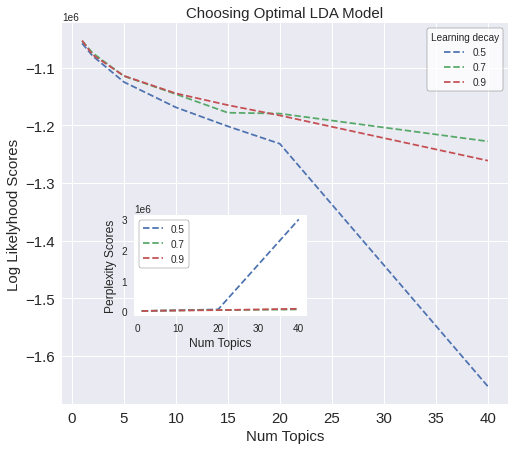

In [25]:
# vectorizer
vectorizer, vectors, feature_names = lda_preprocess(text, n_features=n_features)

# lda gridsearch
lda_gridsearch(vectors)


In [26]:
# best topic model

n_components = 2
learning_decay = 0.9

model = lda_topic_modeling(vectors, n_components, learning_decay, n_top_words)


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


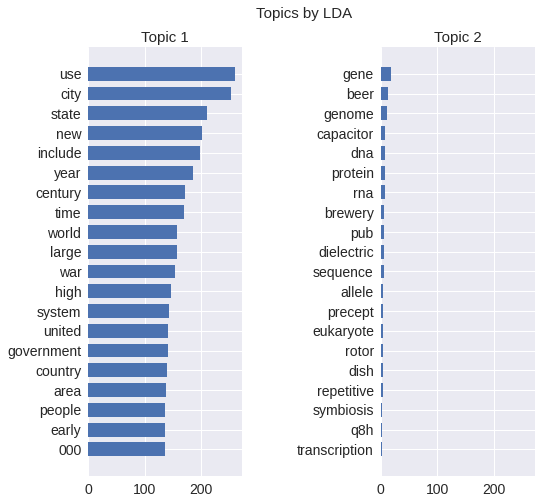

In [27]:
# topic words, document distribution, plot top 10 words in each topic

df_document_topics, df_topic_distribution, df_topic_keywords = major_topic_per_doc(model, vectors, 
                                                                                   vectorizer, text)

plot_top_words(model, feature_names, n_top_words, 1, n_components, (8, 7))
    
df_topic_keywords = show_topics(vectorizer, model, n_words=n_words)


In [28]:
df['topic_number'] = df_document_topics.data['dominant_topic'].values.tolist()

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
df_s = df[df['data_name']=='squad']
df_b = df[df['data_name']=='otquad']
print(df_s.shape, df_b.shape)

(18891, 3) (144, 3)


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
total_s = df_s.shape[0] 
total_b = df_b.shape[0]

print(f'Ratio of topic-0 in SQuAD: {(df_s.topic_number.value_counts()[0]/total_s)*100}')
print(f'Ratio of topic-1 in SQuAD: {(df_s.topic_number.value_counts()[1]/total_s)*100}')
print('\n')
print(f'Ratio of topic-0 in OTQuAD: {(df_b.topic_number.value_counts()[0]/total_b)*100}')
print(f'Ratio of topic-1 in OTQuAD: {(df_b.topic_number.value_counts()[1]/total_b)*100}')

Ratio of topic-0 in SQuAD: 99.6241596527447
Ratio of topic-1 in SQuAD: 0.37584034725530674


Ratio of topic-0 in OTQuAD: 99.30555555555556
Ratio of topic-1 in OTQuAD: 0.6944444444444444


/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
df_s['topic_number'].value_counts()

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    18820
1       71
Name: topic_number, dtype: int64

In [44]:
df_b['topic_number'].value_counts()

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    143
1      1
Name: topic_number, dtype: int64

In [45]:
df_topic_distribution

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic Num,Num Documents
0,0,18963
1,1,72


In [46]:
df_topic_keywords

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,use,city,state,new,include,year,century,time,world,large
Topic 1,gene,beer,genome,capacitor,dna,protein,rna,brewery,pub,dielectric


In [47]:
from kmeans import kmeans_topic_clustering

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
df.loc[df['data_name'] == 'squad', 'data_name_binary'] = 0
df.loc[df['data_name'] == 'otquad', 'data_name_binary'] = 1
labels = df['data_name_binary'].values.tolist()

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.cluster import KMeans
# from sklearn.manifold import TSNE
# mpl.style.use("seaborn")
# mpl.rcParams['legend.frameon'] = 'True'


# def kmeans_topic_clustering(model,
#                             vectors,
#                             n_clusters=2,
#                             cluster_size=12000,
#                             fontsize=15):
#   """
#   input : model, vector repr. of the texts
#   output: a segregation of topic clusters
#   """

#   model_output = model.fit_transform(vectors)
#   tsne_model = TSNE(n_components=2, random_state=42)  # 2 components
#   model_output_tsne = tsne_model.fit_transform(model_output)

#   KM = KMeans(n_clusters=n_clusters, random_state=42)
#   clusters = labels #KM.fit_predict(model_output_tsne)
# #   centroids = KM.cluster_centers_

#   x = model_output_tsne[:, 0]
#   y = model_output_tsne[:, 1]

#   # Plot
#   colors = [
#       '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
#       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
#   ]

#   plt.figure(figsize=(8, 7))

#   plt.scatter(x, y, c=[colors[int(c)] for c in clusters], alpha=0.3)
# #   plt.scatter(centroids[:, 0],
# #               centroids[:, 1],
# #               marker='*',
# #               color="black",
# #               s=150)
# #   plt.scatter(centroids[:, 0],
# #               centroids[:, 1],
# #               marker='o',
# #               color=[colors[i] for i in range(len(centroids))],
# #               s=cluster_size,
# #               alpha=0.3)
#   plt.xlabel('Component 1', fontsize=fontsize)
#   plt.ylabel('Component 2', fontsize=fontsize)
#   plt.xticks(fontsize=fontsize - 1)
#   plt.yticks(fontsize=fontsize - 1)
#   plt.title(f"Segregation of topic clusters in the documents",
#             fontsize=fontsize)
#   plt.show()

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
# # plot topic clusters

# # kmeans
# cluster_size = 0
# kmeans_topic_clustering(model, vectors, n_clusters=n_components, cluster_size=cluster_size)

# pyldavis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, vectors, vectorizer, mds='tsne')
panel

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/QA/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=               x           y  topics  cluster      Freq
topic                                                  
0     -60.312317  141.369629       1        1  90.85417
1      60.312561 -141.369141       2        1   9.14583, topic_info=             Term       Freq      Total Category  logprob  loglift
13241        gene  20.000000  20.000000  Default  30.0000  30.0000
4646         beer  15.000000  15.000000  Default  29.0000  29.0000
13292      genome  13.000000  13.000000  Default  28.0000  28.0000
10086         dna  16.000000  16.000000  Default  27.0000  27.0000
24634         pub  18.000000  18.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
9887         dish   1.633627   5.902314   Topic2  -8.7330   1.1073
32994     winding   1.307701   3.333738   Topic2  -8.9555   1.4560
30819  transcribe   1.228135   3.232978   Topic2  -9.0183   1.4240
18947    mandolin   1.425205  15.148897   Topic2  -8.8695   0.0283
21978      opioid   1.316076  34.604494   Topic2  -8.9491  -0.8775

[123 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          1  0.999746      000
1972       1  0.554653      abv
1972       2  0.554653      abv
2168       2  0.890163  adenine
2680       1  0.318733   allele
...      ...       ...      ...
33144      1  0.582381     wort
33144      2  0.582381     wort
33332      1  0.996512     year
33337      1  0.450165    yeast
33337      2  0.450165    yeast

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])